# Model of auxotrophic communities with mutations in update and production rates of amino acids

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))


## Load Data and set experimentally measured parameters

In [2]:
#init dictionary to store fit parameters
fit_pars = {} 

#init dictionary width measured growth rates
growth_rates = {'WT':0.52, # place holder need to be measured
                'dP':0.45,
                'dT':0.52,
                'dP_trpOP':0.47, # tryptophan overproduction
                'dT_proOP':0.42, # proline overproduction
                'dPro_proUp':0.18} # proline uptake mutant

#load data
df_all = pd.read_csv('community_data.csv')

#average over technical replicates
df_all['Identifier'] = df_all.apply(lambda row: f"{row['Condition']}-{row['Rep']}", axis=1)
df = df_all.groupby('Identifier').agg({'Width': 'mean', 'dT_patch': 'mean', 'dP_patch': 'mean', 'Ratio': 'mean', 'Condition': 'first', 'Rep': 'first'}).reset_index()

#add relative patch width
df['rel_range'] = df['dP_patch']/df['dT_patch']
df.head(n=9)


,Identifier,Width,dT_patch,dP_patch,Ratio,Condition,Rep,rel_range
0,A-1,120.791468,9.982812,43.561364,0.247835,A,1,4.363636
1,A-2,157.898035,7.713991,29.948438,0.274676,A,2,3.882353
2,A-3,73.479304,10.890341,31.536612,0.225064,A,3,2.895833
3,A-4,73.070673,10.436577,19.511861,0.265547,A,4,1.869565
4,A-5,103.484977,9.529048,87.803374,0.263668,A,5,9.214286
5,A-6,70.411315,9.302166,20.192507,0.279767,A,6,2.170732
6,B-1,134.280570,9.075284,4.991406,0.463751,B,1,0.550000
7,B-2,169.978639,160.632528,83.265732,0.410185,B,2,0.518362
8,B-3,280.877680,7.487109,11.117223,0.356883,B,3,1.484848


In [6]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    community: community object
    
    Returns:
    fig: figure object
    
    '''

    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,30,1000)
    community.calc_growth_profiles(x_vec)
    #community.calc_growth_profiles_sectors()
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    
    # ax.plot(community.x_sector_T, community.mu_profile_sector_T/muWT, color=yellow, label='dT sect', linestyle='--')
    # ax.plot(community.x_sector_P, community.mu_profile_sector_P/muWT, color=blue, label='dP sect', linestyle='--')    
    
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

def report_data(df, condition):
    df_sum = df[df['Condition']==condition]
    
    rel_growth = df_sum["Width"].mean()  / df.loc[df['Condition']=='WT']['Width'].mean() 
    sector_ratio = df_sum['dP_patch'].mean() / df_sum['dT_patch'].mean()
    
    print(f"Exp. Community {condition:s}: f(dT) = {df_sum['Ratio'].mean() :.2f}, rel. growth = {rel_growth:.2f}, sectors dT = {df_sum['dT_patch'].mean() :.2f}um, sectors dP = {df_sum['dP_patch'].mean() :.2f}um,  sector ratio = {sector_ratio:.2f}")
    return None

---

### Check original community

We can now check the properties of the original community to confirm we find the same values as in table S3 of our paper.
There are minor differences as there was a small error in our paper in the conversion of interaction range to number of neighbors.

We also plot the growth rate profiles across the interface. The dotted vertical lines represent the calculated growth range.
The dashed lines show curves for sector width

Frequency dT = 0.20
Clustering dT = 0.89, Clustering dP = 0.99
Growth relative to WT = 0.12
Growth defect spatial community = 0.91
mu_max dP = 0.75, mu_max dT = 0.22
range dP = 11.46um, range dT = 2.50um, range dP/dT = 4.59


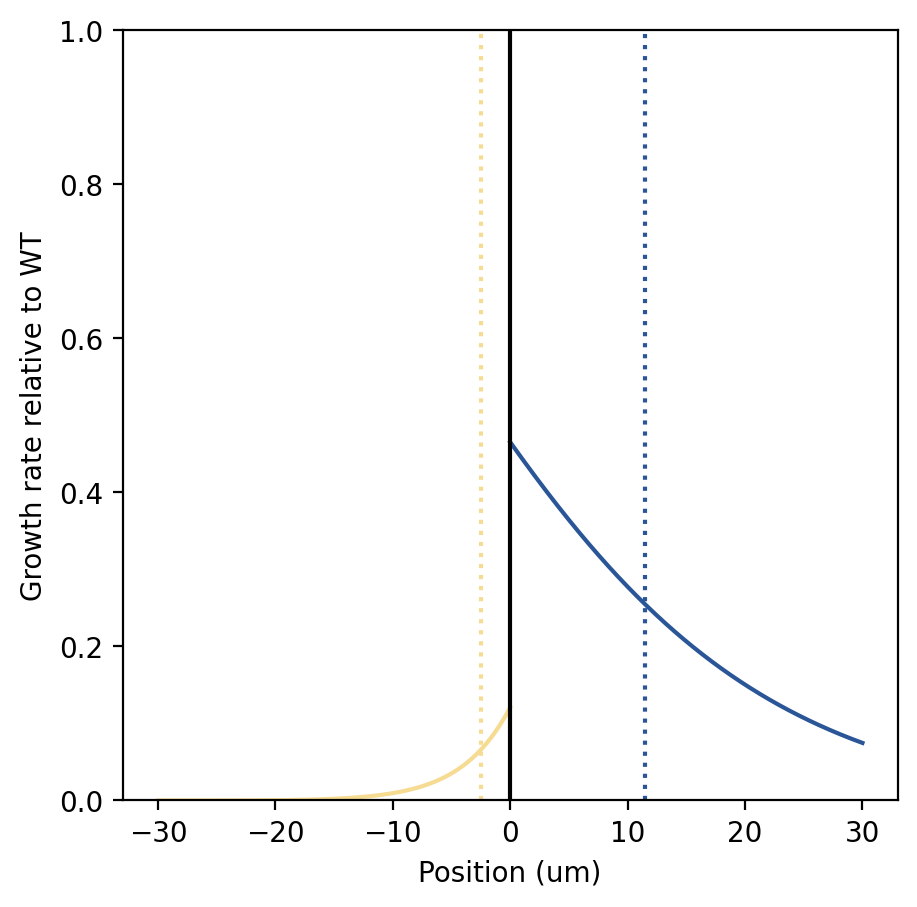

In [7]:
ploscb_community = community()
ploscb_community.report_properties()
fig = plot_growth_profile(ploscb_community)

### Check Community A (dT + dP)

Frequency dT = 0.26
Clustering dT = 0.90, Clustering dP = 0.99
Growth relative to WT = 0.17
Growth defect spatial community = 0.94
mu_max dP = 0.34, mu_max dT = 0.13
range dP = 12.69um, range dT = 2.55um, range dP/dT = 4.97
Exp. Community A: f(dT) = 0.26, rel. growth = 0.09, sectors dT = 9.64um, sectors dP = 38.76um,  sector ratio = 4.02


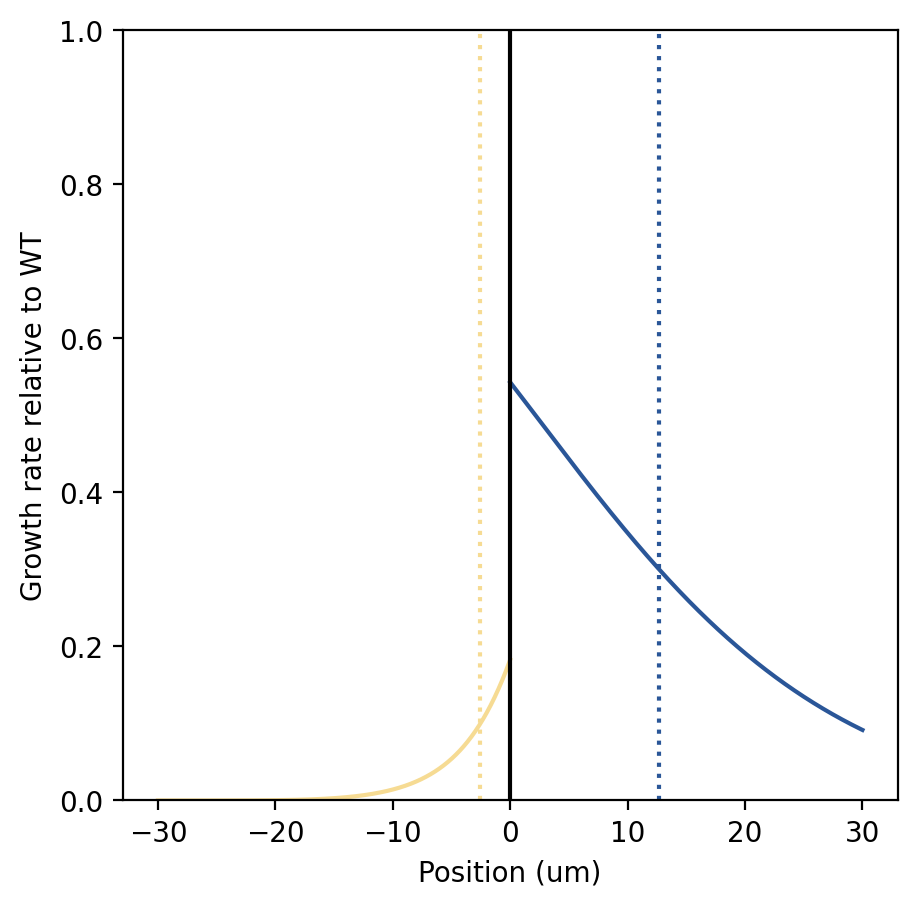

In [8]:
community_A = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_A.report_properties()
fig = plot_growth_profile(community_A)
report_data(df, 'A')

---

### Fit cost function

In [9]:
def fit_1D(x, y_data, y_model):
    
    #check if y data is numpy array
    if isinstance(y_data, np.ndarray):
        delta = (y_model[np.newaxis,:] - y_data[:,np.newaxis])
        L2_norm = (delta**2).sum(axis=0)
    else:
        delta = y_model[np.newaxis,:] - y_data
        L2_norm = (delta**2)
    
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]
    fitted_y = y_model[min_idx]
    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    return (fitted_x, fitted_y)    

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2)


    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)

def fit_3D(x, y, z1, z2, z3, z1_data, z2_data, z3_data):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)
    
    delta3 = (z3[:, :, np.newaxis] - z3_data[np.newaxis, np.newaxis, :])/z3_data[np.newaxis, np.newaxis, :]
    L2_norm3 = (delta3**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2 + L2_norm3)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,4,figsize=(20,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')


    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    im2 = axs[2].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[2])
    axs[2].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[2].contour(x, y, z2, levels=[z2_data.mean()], colors='c')
    axs[2].contour(x, y, z3, levels=[z3_data.mean()], colors='r')
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')

    im3 = axs[3].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im3, ax=axs[3])
    axs[3].axvline(x=xfit, color='k', linestyle='--')
    axs[3].axhline(y=yfit, color='k', linestyle='--')


    return (xfit, yfit)


---
## Try to fit density based on community A

We fit density based on sector size from WT community, we assume that sector size is limited such that all cells are within interaction range from partner type, in other words the sector size equals 2x the interaction range.

This does not work well, we cannot find a density that matches both types well enough.

rho = 0.60, sector dP = 38.76um, range DP = 15.45, sector dT = 9.64um, range DT = 3.11


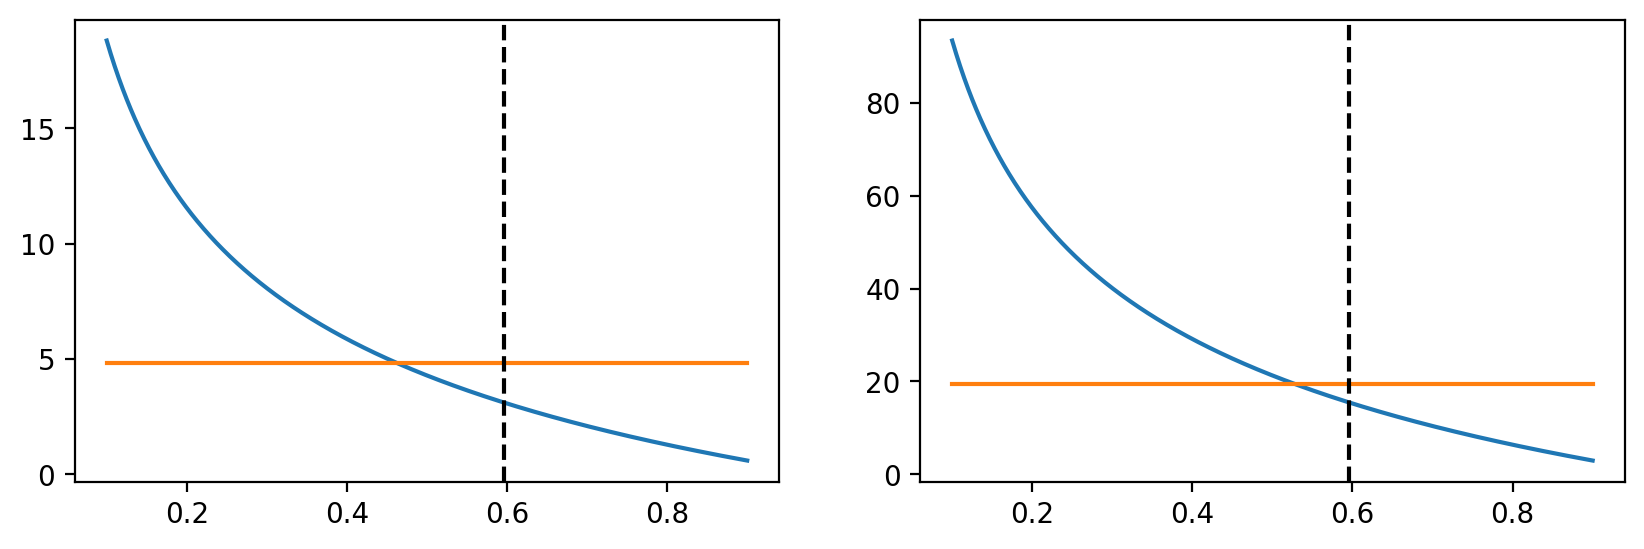

In [12]:
rho_vec = np.linspace(0.1,0.9,801)
community_A_fit = community(rho=rho_vec, mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])

sectorT = df.loc[df['Condition']=='A']['dT_patch'].values 
sectorP = df.loc[df['Condition']=='A']['dP_patch'].values

est_rangeT = sectorT/2
est_rangeP = sectorP/2
deltaT = (community_A_fit.rangeT[np.newaxis,:] - est_rangeT[:,np.newaxis])/est_rangeT[:,np.newaxis]
deltaP = (community_A_fit.rangeP[np.newaxis,:] - est_rangeP[:,np.newaxis])/est_rangeP[:,np.newaxis]
L2_norm = (deltaT**2).sum(axis=0) + (deltaP**2).sum(axis=0)
min_idx = np.argmin(L2_norm)

rho_opt = rho_vec[min_idx]

print(f"rho = {rho_opt:.2f}, sector dP = {sectorP.mean():.2f}um, range DP = {community_A_fit.rangeP[min_idx]:.2f}, sector dT = {sectorT.mean():.2f}um, range DT = {community_A_fit.rangeT[min_idx]:.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(rho_vec, community_A_fit.rangeT, label='model')
axs[0].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeT), label='data')
axs[0].axvline(x=rho_opt, color='k', linestyle='--')

axs[1].plot(rho_vec, community_A_fit.rangeP, label='model')
axs[1].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeP), label='data')
axs[1].axvline(x=rho_opt, color='k', linestyle='--')

---

## Fit Leakage rates based on community A

Pro leakage = 4.33e-06 (original = 1.59e-05), Trp leakage = 4.23e-07 (original = 6.04e-07)
Exp. Community A: f(dT) = 0.26, rel. growth = 0.09, sectors dT = 9.64um, sectors dP = 38.76um,  sector ratio = 4.02


Frequency dT = 0.25
Clustering dT = 0.89, Clustering dP = 0.99
Growth relative to WT = 0.10
Growth defect spatial community = 0.92
mu_max dP = 0.49, mu_max dT = 0.18
range dP = 10.54um, range dT = 2.49um, range dP/dT = 4.24


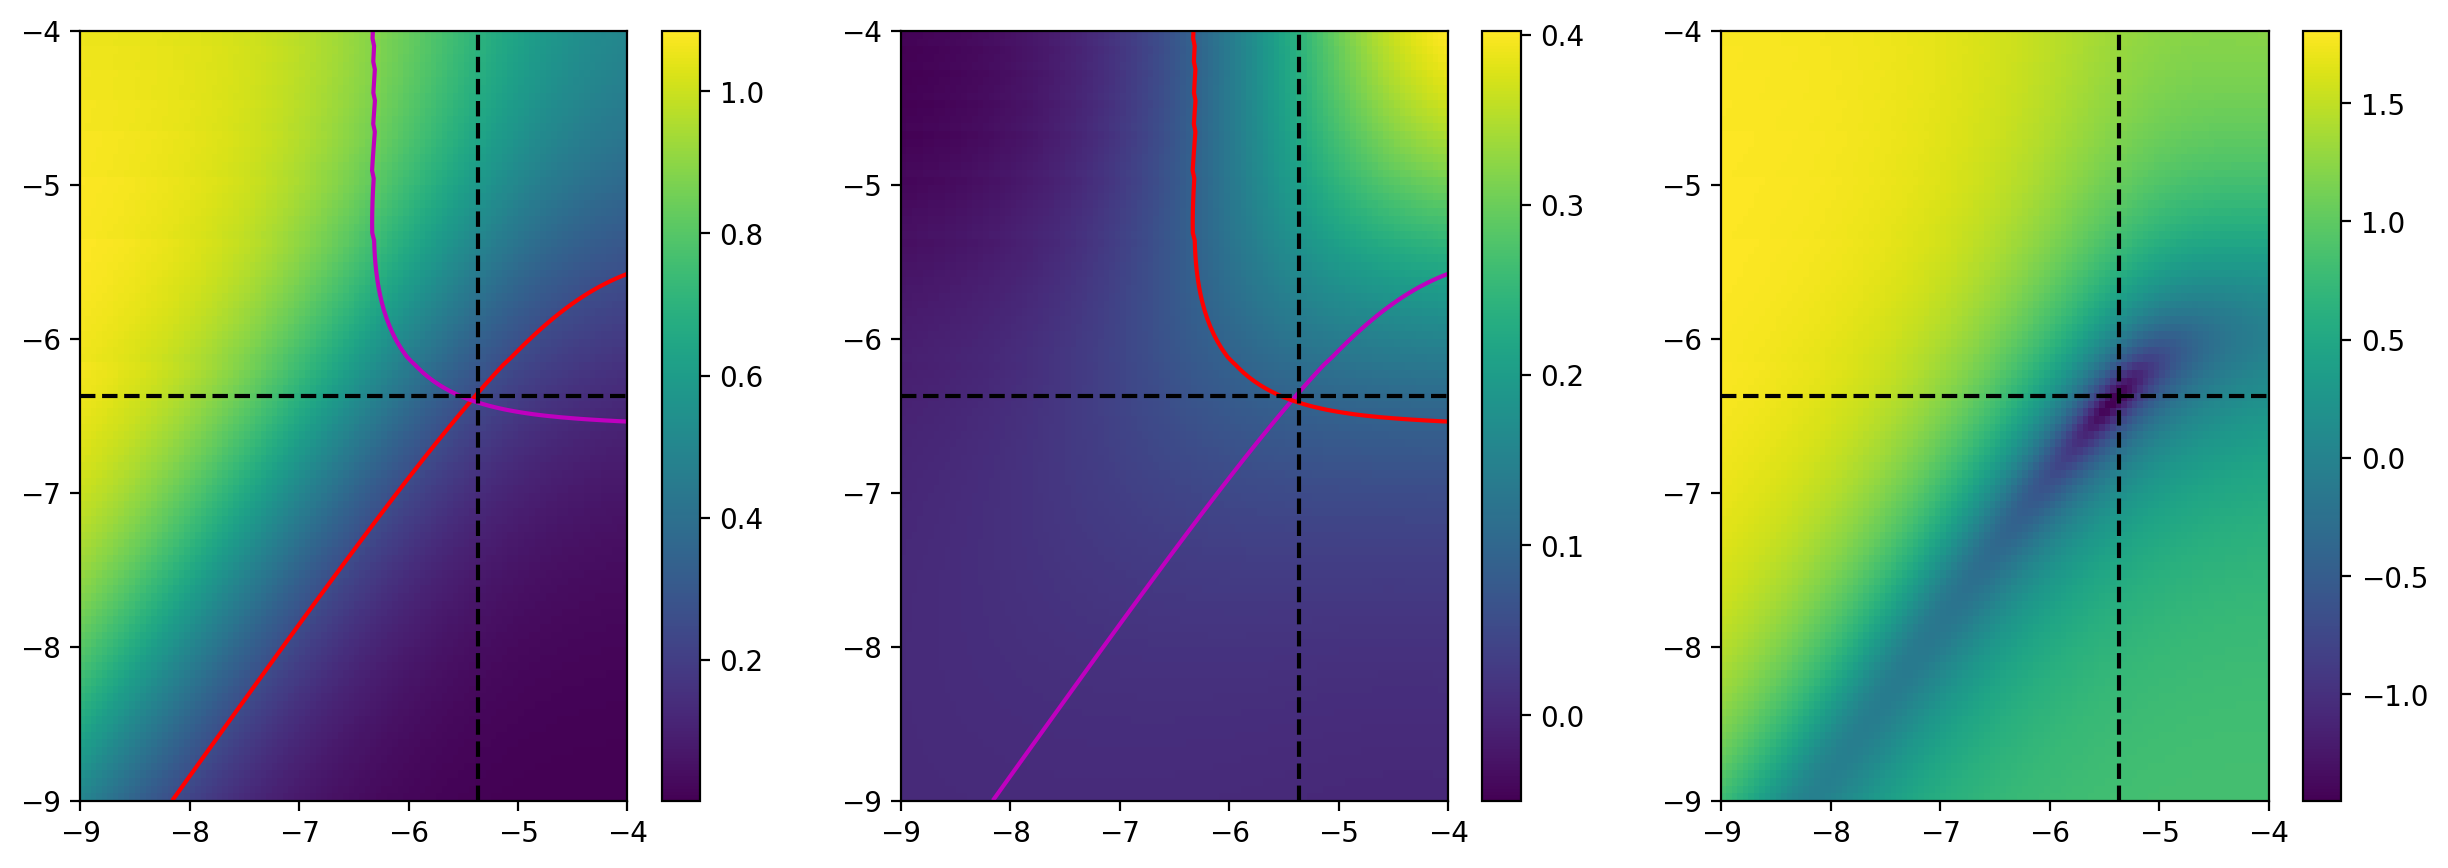

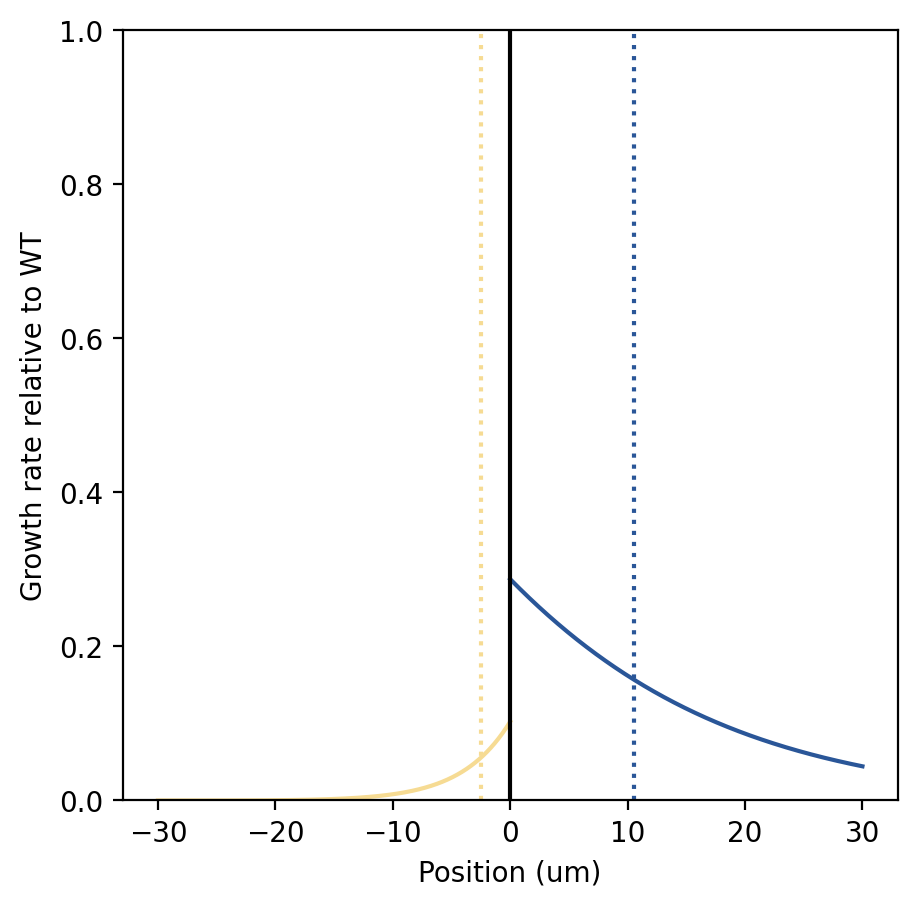

In [14]:
lPro = np.linspace(-9,-4,100)
lTrp = np.linspace(-9,-4,100)

xmat, ymat = np.meshgrid(lPro, lTrp)

eq_data = df.loc[df['Condition']=='A']['Ratio'].values 
growth_data = df.loc[df['Condition']=='A']['Width'].mean() / df.loc[df['Condition']=='WT']['Width'].mean() 

community_A_test = community(lPro=10**xmat, lTrp=10**ymat)

x = lPro
y = lTrp
z1 = community_A_test.eq
z1_data = eq_data

z2 = community_A_test.rel_growth_wt
z2_data = np.atleast_1d(np.array(growth_data))

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

lPro_fit = 10**xfit
lTrp_fit = 10**yfit

print(f"Pro leakage = {lPro_fit:.3g} (original = {ploscb_community.lPro:.3g}), Trp leakage = {lTrp_fit:.3g} (original = {ploscb_community.lTrp:.3g})")
report_data(df, 'A')

print("\n")
community_A_fit = community(lPro=lPro_fit, lTrp=lTrp_fit)
community_A_fit.report_properties()
fig = plot_growth_profile(community_A_fit)

fit_pars['lPro'] = lPro_fit
fit_pars['lTrp'] = lTrp_fit

---
## Characterize putP using community B

### fit increase in Pro uptake by putP over expression (assuming no cost)

First we fit increase in uptake base on change in growth range

### PutP over expression with costs from community B

we have two variables: cost and increase in uptake, and two measurement: change in ratio and change in sector size

fold change Pro uptake = 123.616, cost putP = 0.175


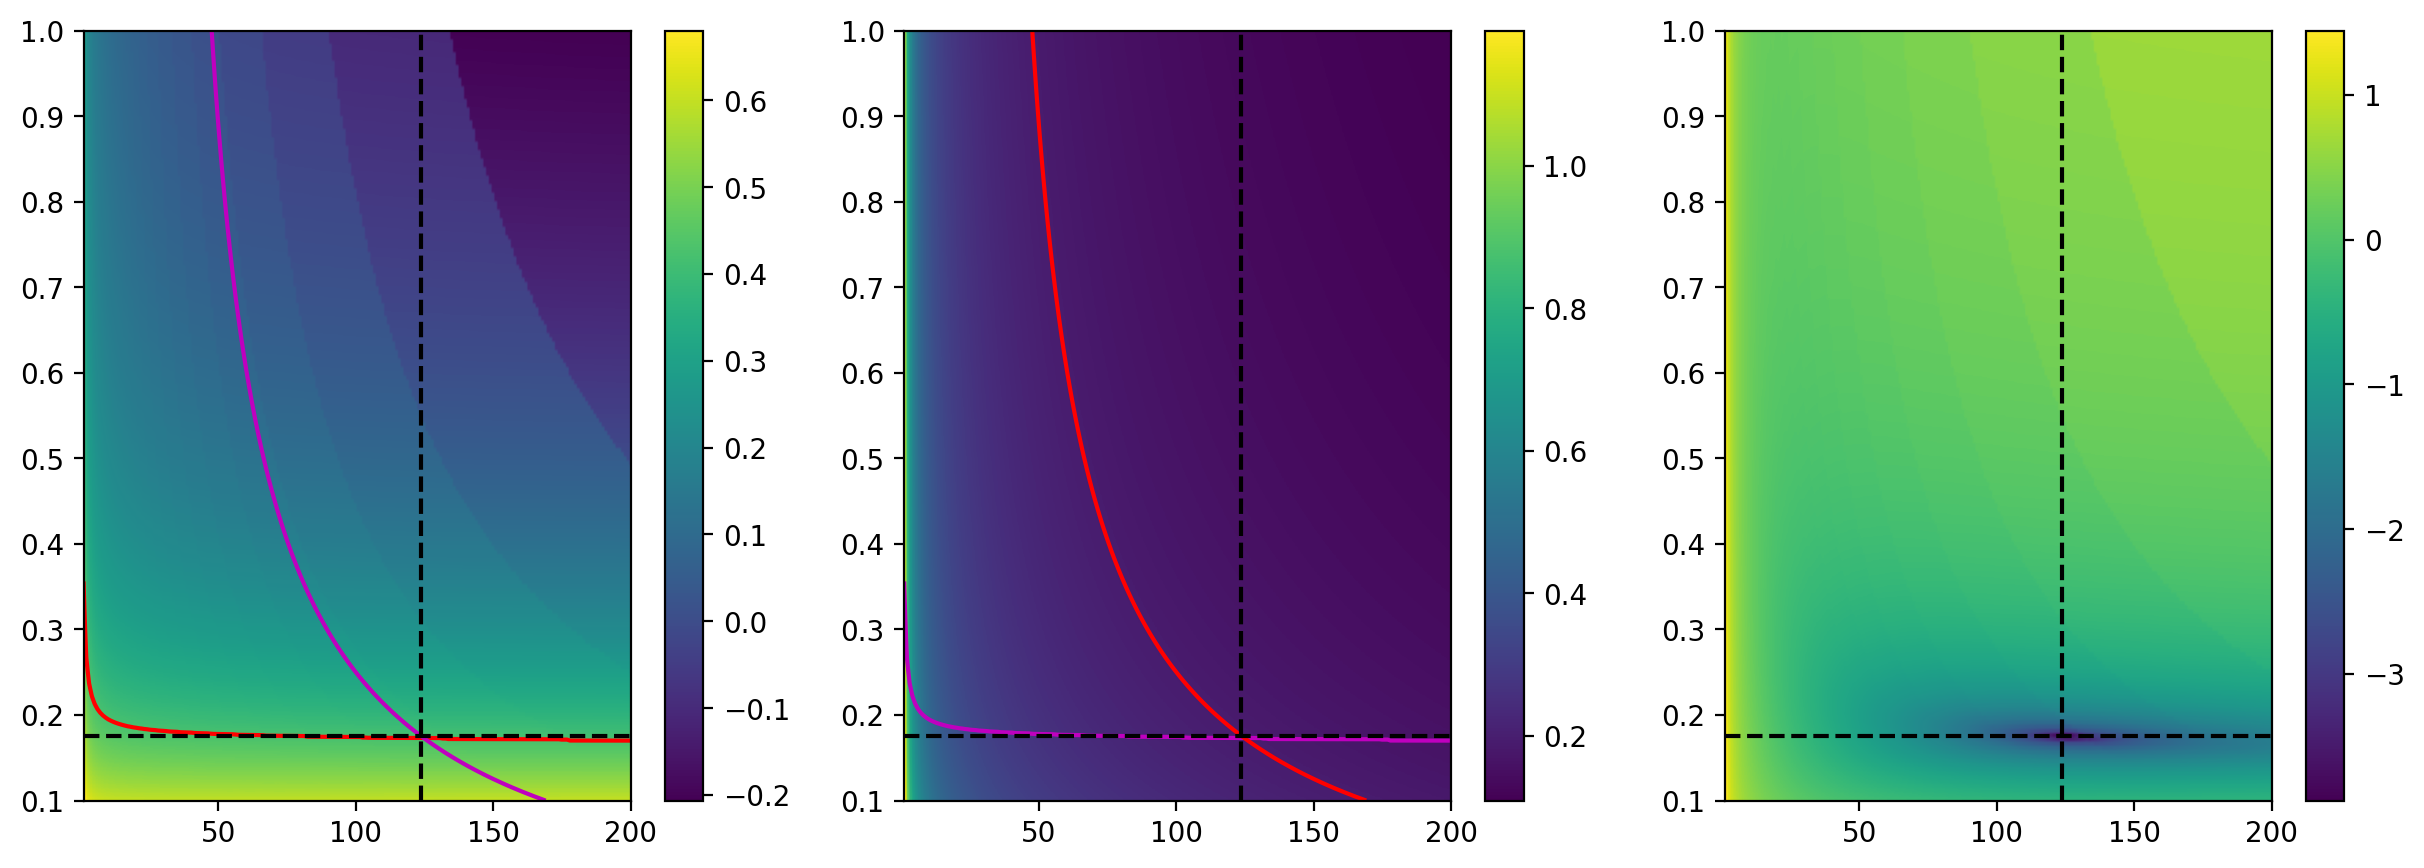

In [ ]:
c_up_P = np.linspace(1,200,199)
cost_putP = np.linspace(0.1,1,181)

x = c_up_P
y = cost_putP

xmat, ymat = np.meshgrid(x, y)
eq_data = df.loc[df['Condition']=='B']['Ratio'].values 
rel_dP_patch_data = df.loc[df['Condition']=='B']['dP_patch'].mean() / df.loc[df['Condition']=='A']['dP_patch'].mean()

community_A_fit = community(lPro=lPro_fit, lTrp=lTrp_fit)
community_B = community(c_up_P=xmat, c_cost_dP=ymat, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp']) 

z1 = community_B.eq
z1_data = eq_data

z2 = community_B.rangeP / community_A_fit.rangeP
z2_data = np.atleast_1d(rel_dP_patch_data)

c_up_P_fit, cost_putP_fit = fit_2D(x, y, z1, z2, z1_data, z2_data)

print(f"fold change Pro uptake = {c_up_P_fit:.3f}, cost putP = {cost_putP_fit:.3f}")

fit_pars['c_up_P'] = c_up_P_fit
fit_pars['cost_putP'] = cost_putP_fit

----

## Characterize trpR using community C



### Fit trpR cost and increase in trp release for community C based on EQ data - assuming no cost

fold change Trp leakage = 22.00, EQ pred = 0.59, EQ data = 0.59


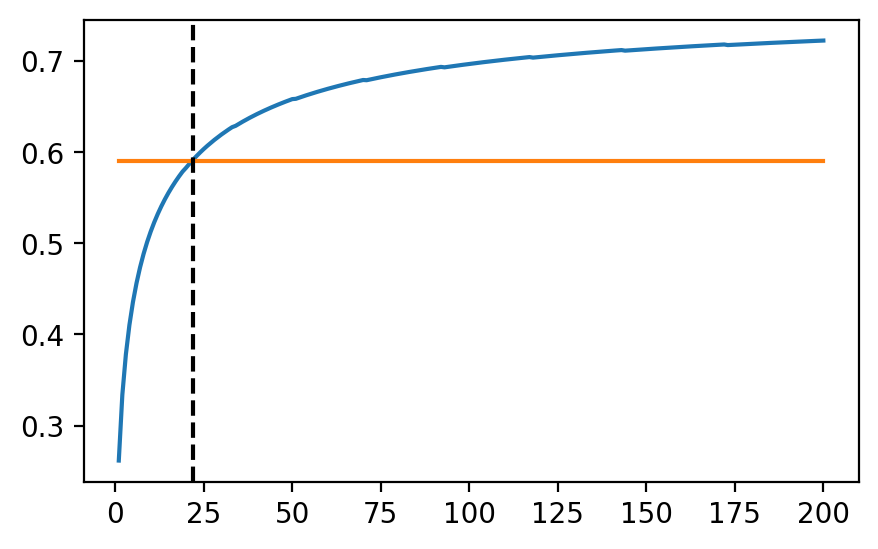

In [ ]:
#get measured value
eq_data = df.loc[df['Condition']=='C']['Ratio'].values 

#calc model predictions with varying cost for putP
c_prod_T = np.linspace(1,200,200)
community_C_prod_mod = community(c_prod_T=c_prod_T, c_cost_dP=1, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_fit2, eq_fit = fit_1D(c_prod_T, eq_data, community_C_prod_mod.eq)
#report fitted cost
print(f"fold change Trp leakage = {c_prod_fit2:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")
fit_pars['c_prod_T'] = c_prod_fit2

----

## Characterize proB74 using community E



### Fit proB74 cost and increase in pro release for community E based on EQ data - assuming no cost

fold change Pro leakage = 2.91, EQ pred = 0.19, EQ data = 0.19


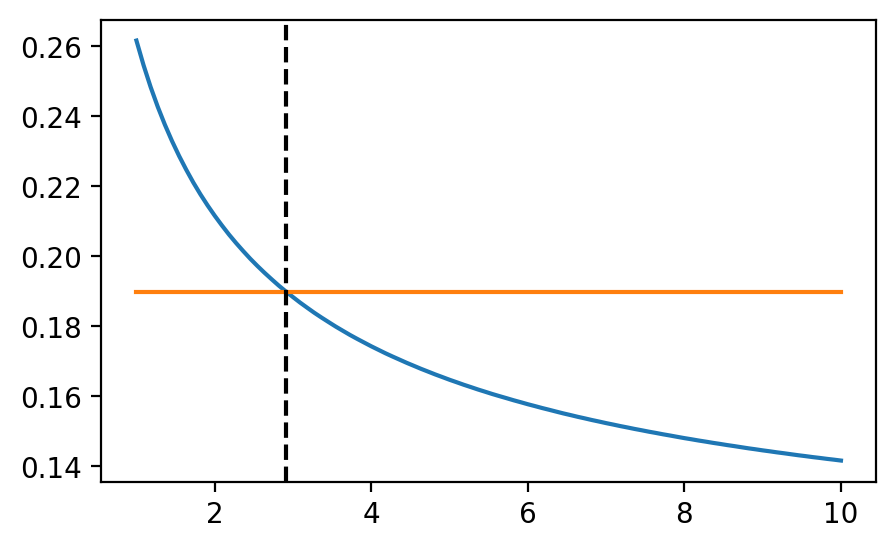

In [ ]:
#get measured value
eq_data = df.loc[df['Condition']=='E']['Ratio'].values 

#calc model predictions with varying cost for putP
c_prod_P = np.linspace(1,10,100)
community_E_prod_mod = community(c_prod_P=c_prod_P, c_cost_dT=1, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])

#find cost that minimized L2 norm, based on rel patch size between dT and dP
c_prod_P_fit2, eq_fit = fit_1D(c_prod_P, eq_data, community_E_prod_mod.eq)
#report fitted cost
print(f"fold change Pro leakage = {c_prod_P_fit2:.2f}, EQ pred = {eq_fit:.2f}, EQ data = {eq_data.mean():.2f}")
fit_pars['c_prod_P'] = c_prod_P_fit2

---
## Characterize putP using community D

### fit increase in Pro uptake by putP over expression (assuming no cost)

First we fit increase in uptake base on change in growth range

### PutP over expression with costs from community D

we have two variables: cost and increase in uptake, and two measurement: change in ratio and change in sector size

fold change Pro uptake = 126.631, cost putP = 0.335


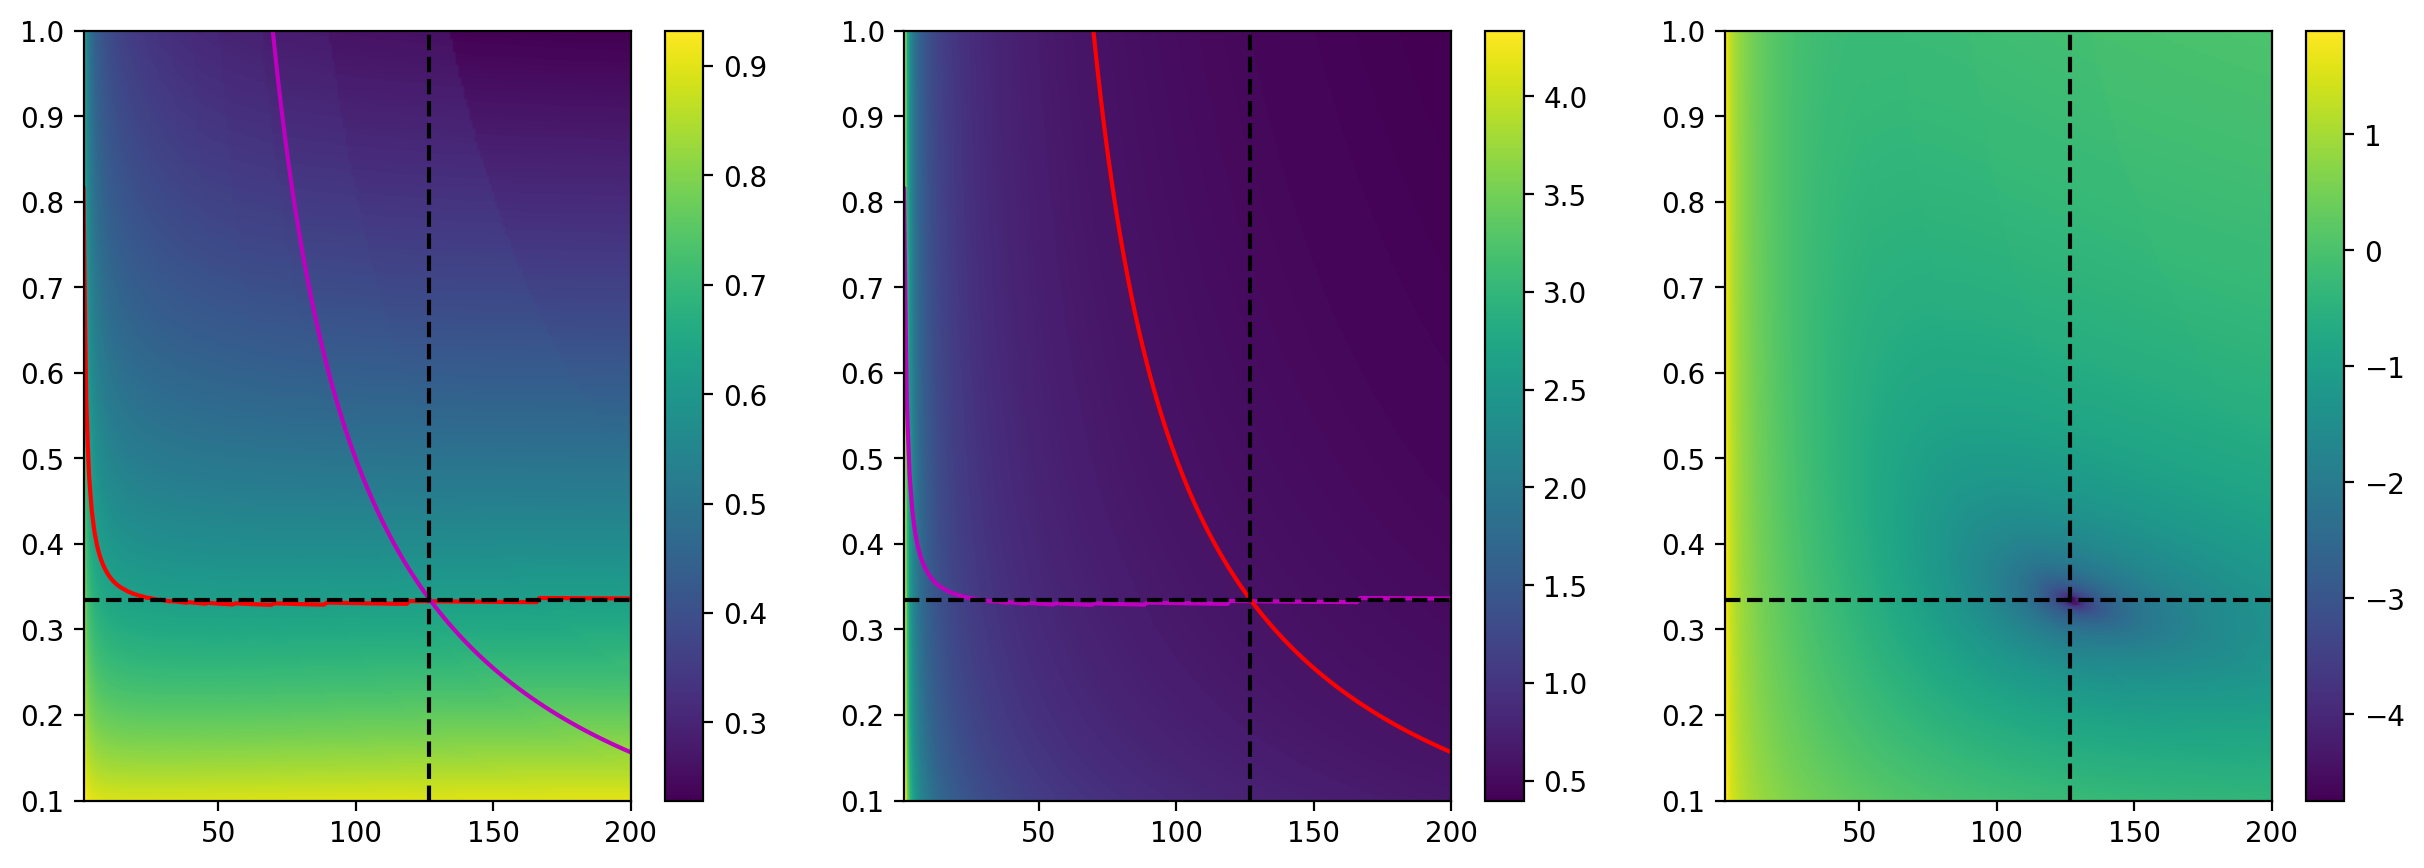

In [ ]:
c_up_P = np.linspace(1,200,199)
cost_putP = np.linspace(0.1,1,181)
xmat = np.repeat(np.atleast_2d(c_up_P), len(cost_putP), axis = 0)
ymat = np.repeat(np.atleast_2d(cost_putP).T, len(c_up_P), axis = 1)

eq_data = df.loc[df['Condition']=='D']['Ratio'].values 
rel_dPdT_patch_data = df.loc[df['Condition']=='D']['rel_range'].values 

community_D = community(c_up_P=xmat, c_cost_dP=ymat, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'],c_prod_T=fit_pars['c_prod_T']) 

x = c_up_P
y = cost_putP
z1 = community_D.eq
z1_data = eq_data
# z1[z1<0] = 0
# z1[z1>1] = 1

z2 = community_D.rangeP / community_D.rangeT
z2_data = rel_dPdT_patch_data

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

c_up_P_fit = xfit
cost_putP_fit = yfit

print(f"fold change Pro uptake = {c_up_P_fit:.3f}, cost putP = {cost_putP_fit:.3f}")

fit_pars['c_up_P2'] = c_up_P_fit
fit_pars['cost_putP2'] = cost_putP_fit

---

## Report fitting results

In [ ]:
print(fit_pars)
#write fitted parameters to csv file
with open('fit_pars_new.csv', 'w') as f:
    for key in fit_pars.keys():
        f.write("%s,%s\n"%(key,fit_pars[key]))

{'lPro': 3.430469286314919e-06, 'lTrp': 3.764935806792471e-07, 'c_up_P': 123.6161616161616, 'cost_putP': 0.175, 'c_prod_T': 22.0, 'c_prod_P': 2.909090909090909, 'c_up_P2': 126.63131313131312, 'cost_putP2': 0.335}
